# Models without tweets features

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold

# visualization library
import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})   

# import matplotlib and allow it to plot inline
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn can generate several warnings, we ignore them
import warnings 
warnings.filterwarnings("ignore")

import missingno as msno
import math

### Load, join and clean datasets

In [52]:
#targets:
#    0: porn
#    1: propaganda
#    2: spam
#    3: fake followers

porn = pd.read_csv('data/porn/users.csv', encoding='utf-8-sig')
porn['target'] = 0

propaganda = pd.read_csv('data/propaganda/users.csv', encoding='utf-8-sig')
propaganda['target'] = 1

spam = pd.read_csv('data/spam/users.csv', encoding='utf-8-sig')
spam['target'] = 2

fake_followers = pd.read_csv('data/fake_followers/users.csv', encoding='utf-8-sig')
fake_followers['target'] = 3

frames = [porn, propaganda, spam, fake_followers]
users = pd.concat(frames, ignore_index=True)

### Visualize missing values

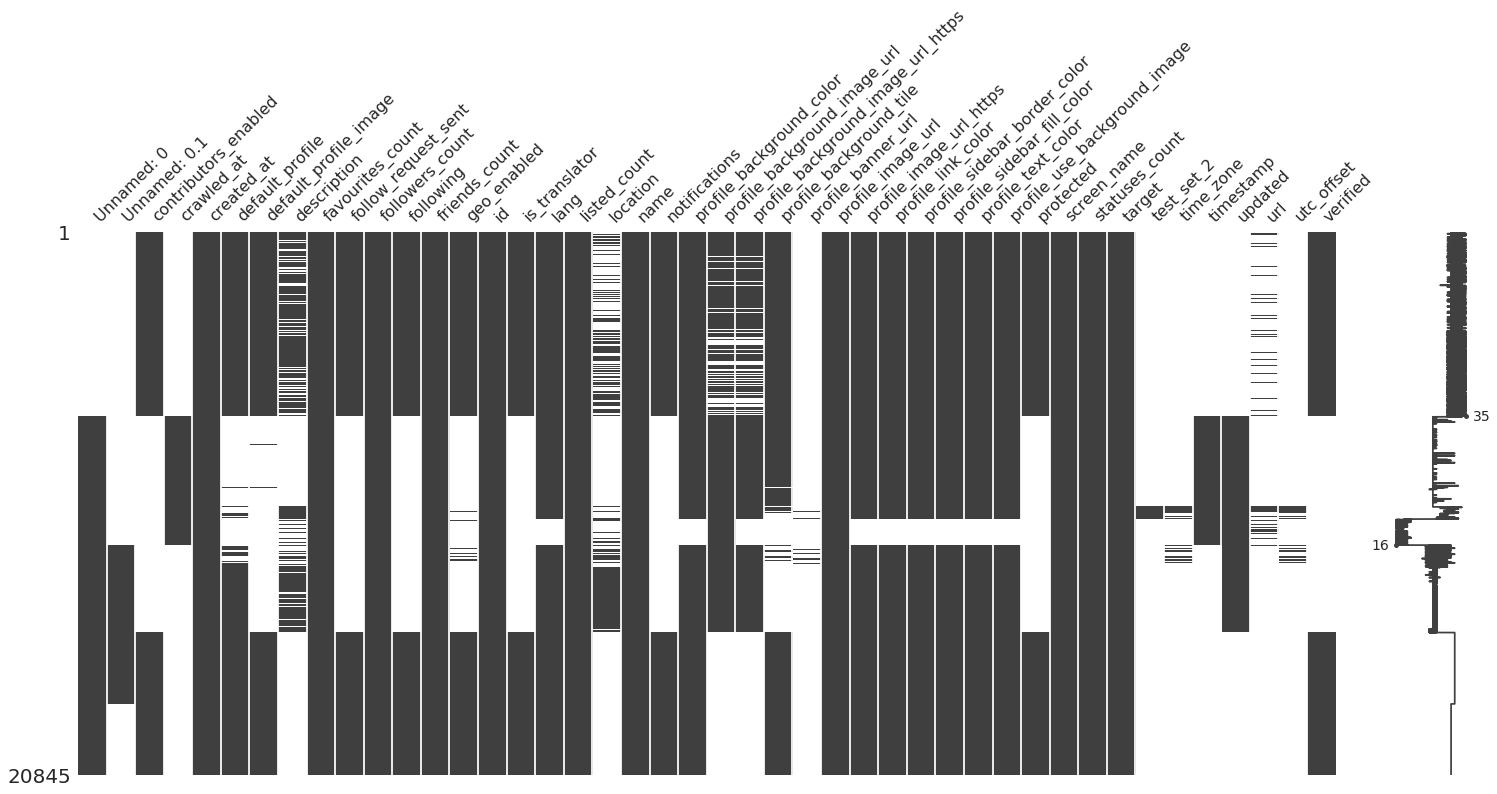

In [53]:
msno.matrix(users)

### remove attributes with a lot of missing values 

In [54]:
users = users.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'contributors_enabled', 'crawled_at', 'follow_request_sent', 'following', 'geo_enabled', 'is_translator', 'notifications', 'profile_banner_url', 'test_set_2', 'time_zone', 'timestamp', 'updated', 'utc_offset', 'protected'], axis=1)

Save cleaned dataset

In [55]:
users.to_csv('data/full/users.csv', encoding='utf-8-sig')

### Remove useless attributes

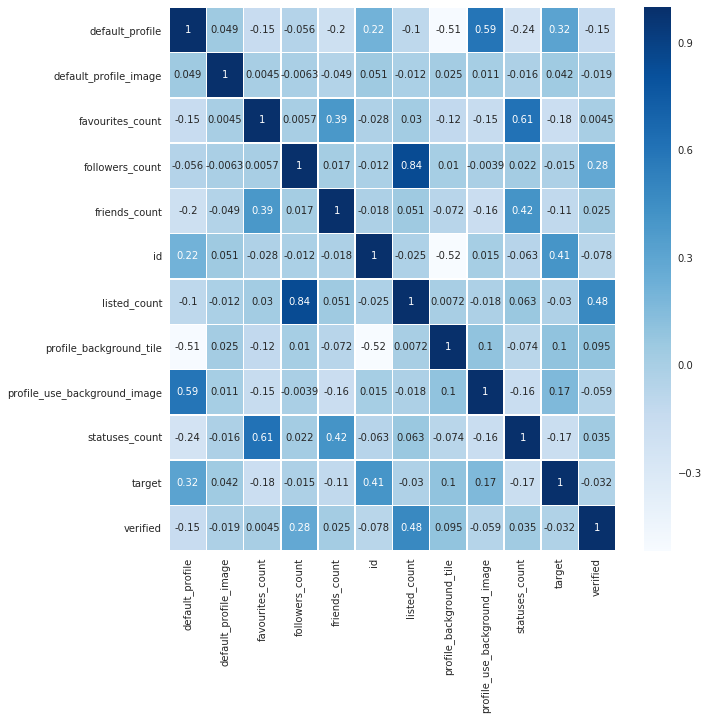

In [56]:
fig, ax = plt.subplots(figsize=(10,10))
cov=users.corr(method='pearson')
sns.heatmap(cov,annot=True,cmap="Blues",linewidths=.5, ax=ax)

In [57]:
users = users.drop(columns=['profile_background_image_url', 'profile_background_image_url_https', 'profile_image_url', 'profile_image_url_https', 'id', 'screen_name'], axis=1)

### Fill missing fields

Distribution of missing values

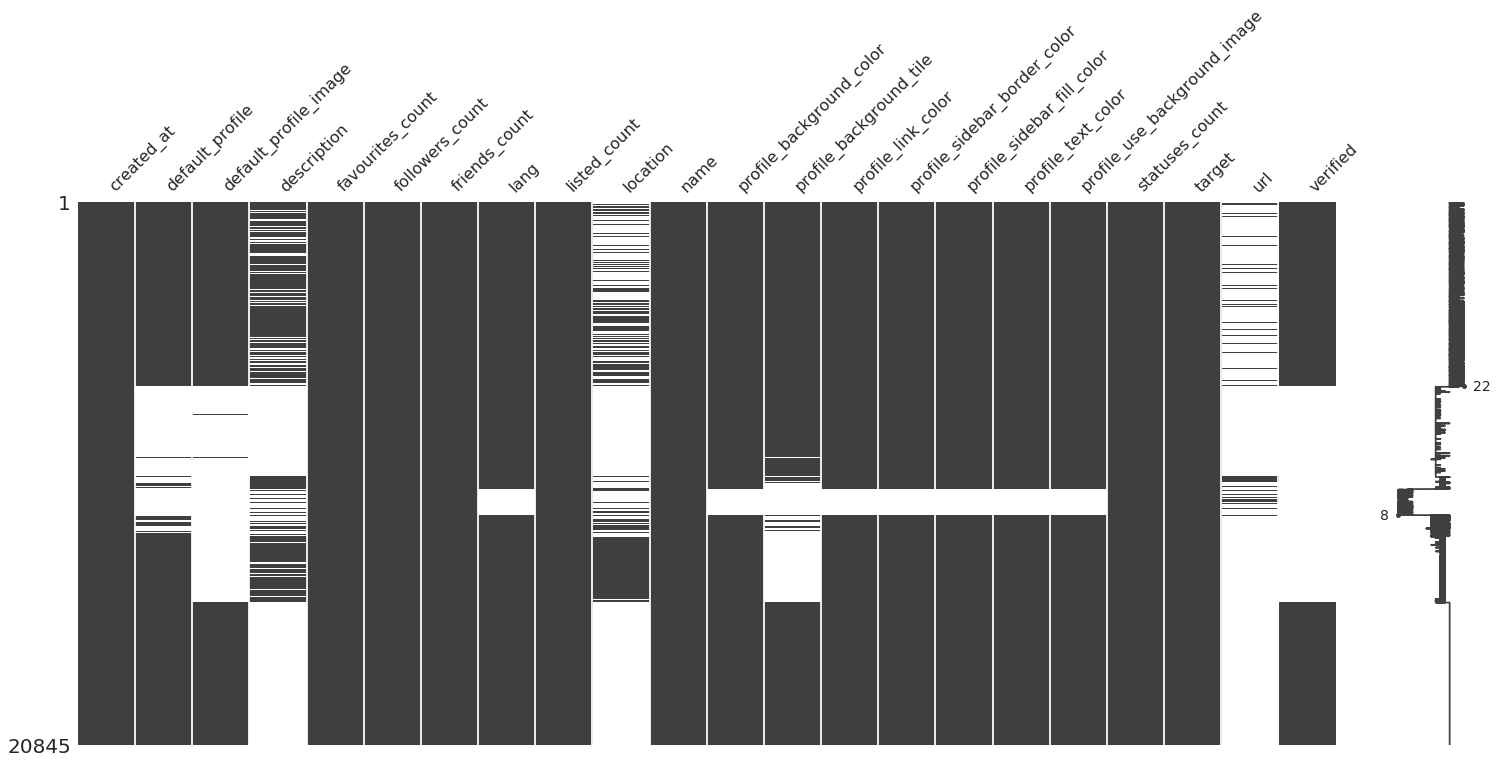

In [58]:
msno.matrix(users)

Fill missing values

In [59]:
users['default_profile'].value_counts()

1.0    14267
0.0     1533
Name: default_profile, dtype: int64

In [60]:
users['default_profile'] = users['default_profile'].fillna(users['default_profile'].mode()[0])

In [61]:
users['default_profile_image'].value_counts()

0.0    11762
1.0      863
Name: default_profile_image, dtype: int64

In [62]:
users['default_profile_image'] = users['default_profile_image'].fillna(users['default_profile_image'].mode()[0])

In [63]:
users['description'] = users['description'].apply(lambda x: int(pd.isnull(x)))

In [64]:
users['lang'].value_counts()[:10]

en       14833
tr        2683
es         480
ru         393
fr         340
pt         294
ko         126
de         121
it         114
zh-cn       66
Name: lang, dtype: int64

In [65]:
users['lang'] = users['lang'].fillna(users['lang'].mode()[0])

In [66]:
users['location'].value_counts()[:10]

USA                109
United States       93
Stati Uniti         55
Texas, USA          54
Brasil              49
California, USA     48
Florida, USA        42
US                  38
London              32
Texas               27
Name: location, dtype: int64

In [67]:
len(users['location'].value_counts())

3822

In [68]:
users = users.drop(columns=['location'], axis=1)

In [69]:
users['profile_background_color'].value_counts()[:5]

C0DEED    7433
F5F8FA    7050
0000FF    3429
000000     575
131516     335
Name: profile_background_color, dtype: int64

In [70]:
users['profile_background_color'] = users['profile_background_color'].fillna(method='ffill')

In [71]:
users['profile_background_tile'].value_counts()

0.0    12132
1.0     4289
Name: profile_background_tile, dtype: int64

In [72]:
users['profile_background_tile'] = users['profile_background_tile'].fillna(method='ffill')

In [73]:
users['profile_link_color'].value_counts()[:5]

1DA1F2    11042
0084B4     3488
0000FF     3438
009999      313
1B95E0      161
Name: profile_link_color, dtype: int64

In [74]:
users['profile_link_color'] = users['profile_link_color'].fillna(users['profile_link_color'].mode()[0])

In [75]:
users['profile_sidebar_border_color'].value_counts()[:5]

C0DEED    14435
FFFFFF     3709
000000      677
EEEEEE      369
65B0DA       85
Name: profile_sidebar_border_color, dtype: int64

In [76]:
users['profile_sidebar_border_color'] = users['profile_sidebar_border_color'].fillna(users['profile_sidebar_border_color'].mode()[0])

In [77]:
users['profile_sidebar_fill_color'].value_counts()[:5]

DDEEF6    18019
000000      581
EFEFEF      328
7AC3EE      102
252429       96
Name: profile_sidebar_fill_color, dtype: int64

In [78]:
users['profile_sidebar_fill_color'] = users['profile_sidebar_fill_color'].fillna(users['profile_sidebar_fill_color'].mode()[0])

In [79]:
users['profile_text_color'].value_counts()[:5]

333333    18632
000000      604
3D1957      106
666666       94
3C3940       69
Name: profile_text_color, dtype: int64

In [80]:
users['profile_text_color'] = users['profile_text_color'].fillna(users['profile_text_color'].mode()[0])

In [81]:
users['profile_use_background_image'].value_counts()

1.0    19259
0.0      574
Name: profile_use_background_image, dtype: int64

In [82]:
users['profile_use_background_image'] = users['profile_use_background_image'].fillna(users['profile_use_background_image'].mode()[0])

In [83]:
users['url'] = users['url'].apply(lambda x: int(pd.isnull(x)))

In [84]:
users['verified'].value_counts()

0.0    12508
1.0       65
Name: verified, dtype: int64

In [85]:
users['verified'] = users['verified'].fillna(users['verified'].mode()[0])

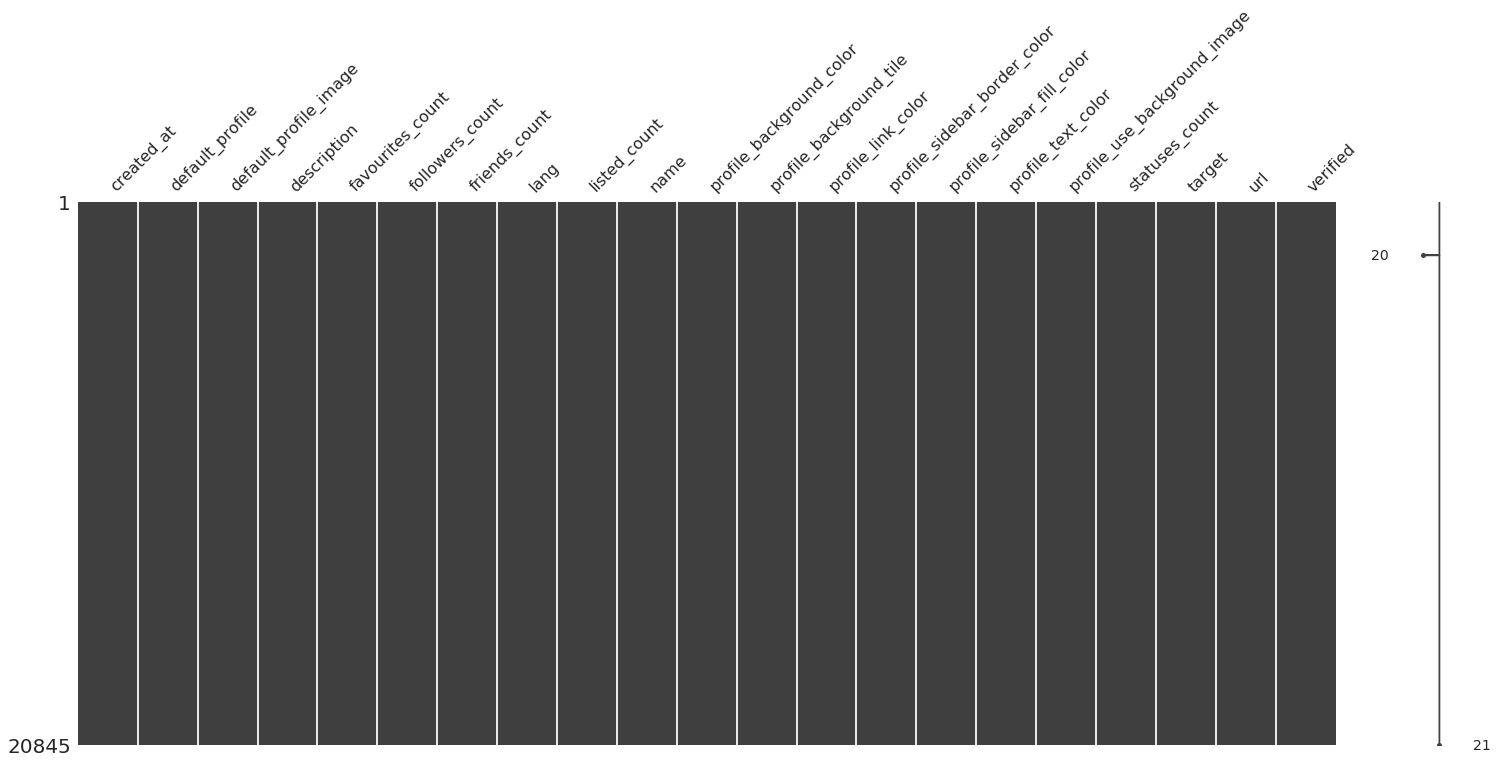

In [86]:
msno.matrix(users)

In [87]:
users.describe()

,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,listed_count,profile_background_tile,profile_use_background_image,statuses_count,target,url,verified
count,20845.000000,20845.000000,20845.000000,20845.000000,2.084500e+04,20845.000000,20845.000000,20845.00000,20845.000000,2.084500e+04,20845.000000,20845.000000,20845.000000
mean,0.926457,0.041401,0.589782,6315.584025,7.473929e+03,1184.791317,38.236604,0.41799,0.972463,9.686903e+03,1.900600,0.926697,0.003118
std,0.261032,0.199220,0.491885,28456.577073,4.001517e+05,4760.925023,998.608149,0.49324,0.163645,4.370222e+04,1.140488,0.260639,0.055756
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,3.000000e+00,66.000000,0.000000,0.00000,1.000000,0.000000e+00,1.000000,1.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,9.000000e+00,221.000000,0.000000,0.00000,1.000000,3.700000e+01,2.000000,1.000000,0.000000
75%,1.000000,0.000000,1.000000,194.000000,4.800000e+01,644.000000,0.000000,1.00000,1.000000,8.500000e+01,3.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,913239.000000,5.254102e+07,191706.000000,89208.000000,1.00000,1.000000,1.418488e+06,3.000000,1.000000,1.000000


In [88]:
users.describe(exclude=[np.number])

,created_at,lang,name,profile_background_color,profile_link_color,profile_sidebar_border_color,profile_sidebar_fill_color,profile_text_color
count,20845,20845,20844,20845,20845,20845,20845,20845
unique,18005,42,17682,276,382,147,199,178
top,Sat Jun 23 15:33:05 +0000 2012,en,Sara,C0DEED,1DA1F2,C0DEED,DDEEF6,333333
freq,5,15833,7,7433,12042,15435,19019,19632


In [89]:
users = users.drop(columns=['created_at', 'lang', 'name', 'profile_background_color', 'profile_link_color', 'profile_sidebar_border_color', 'profile_sidebar_fill_color', 'profile_text_color'], axis=1)

### Create model

In [90]:
target = 'target'
features = users.columns[users.columns!=target]

In [91]:
X = users[features]
y = users[target]

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 21)

In [93]:
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

### Confusion Matrix

In [94]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Target'], colnames=['Predicted Target']))

Predicted Target    0    1     2     3
Actual Target                         
0                 947   32     0     0
1                  32  775     0     0
2                   0    0  1212     4
3                   0    0    15  2195


### Most important features

In [96]:
sorted(zip(map(lambda x: round(x, 2), classifier.feature_importances_), users.columns), reverse=True)[:10]

[(0.23, u'statuses_count'),
 (0.17, u'favourites_count'),
 (0.16, u'profile_background_tile'),
 (0.15, u'friends_count'),
 (0.15, u'followers_count'),
 (0.06, u'listed_count'),
 (0.06, u'description'),
 (0.02, u'default_profile'),
 (0.01, u'default_profile_image'),
 (0.0, u'url')]

### Porn or not (0 or 1)

In [100]:
y_porn = y
y_porn[y_porn!=0] = 1

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y_porn, test_size = 0.25, random_state = 21)

# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [104]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
# Making the Confusion Matrix
pd.crosstab(y_test, y_pred, rownames=['Actual Target'], colnames=['Predicted Target'])

Predicted Target,0,1
Actual Target,,
0,948,31
1,29,4204


In [105]:
sorted(zip(map(lambda x: round(x, 2), classifier.feature_importances_), users.columns), reverse=True)[:10]

[(0.27, u'favourites_count'),
 (0.17, u'statuses_count'),
 (0.14, u'followers_count'),
 (0.12, u'friends_count'),
 (0.11, u'description'),
 (0.08, u'profile_background_tile'),
 (0.08, u'listed_count'),
 (0.03, u'default_profile'),
 (0.01, u'default_profile_image'),
 (0.0, u'url')]